# 데이터 로드 및 사전처리
## 4. images 데이터 로드
#### 참고사이트 : https://www.tensorflow.org/tutorials/load_data/images?hl=ko

In [2]:
import tensorflow as tf

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [4]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

tf.__version__

'2.1.0'

In [5]:
# 학습(훈련)을 시키기 위해서는 데이터가 필요함
# Google creative에서 꽃 사진 tar 파일 다운로드(라이센스는 LICENSE.txt 파일에 존재)
import pathlib
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

In [6]:
# data_dir(~/.keras/datasets/flower_photos)에는 5개의 하위 디렉토리(class)가 존재
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [7]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['daisy', 'tulips', 'sunflowers', 'dandelion', 'roses'],
      dtype='<U10')

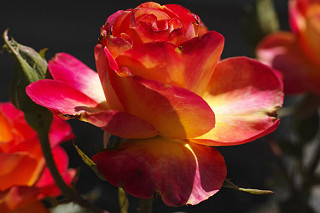

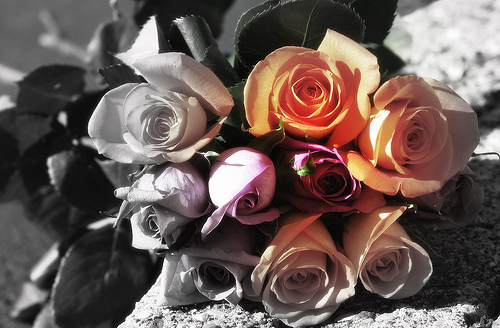

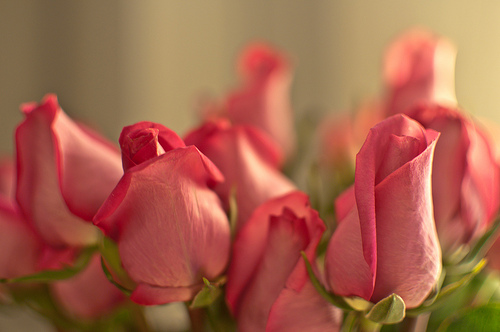

In [8]:
# 각 디렉토리에는 해당 유형의 꽃 이미지가 포함되어 있으며, 아래 예제는 '장미'
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

## 1) keras.preprocessing을 사용한 로드

In [9]:
# 1./255는 uint8를 float32로 변환해줌(0~1 사이 값으로) => 데이터 사이즈 통일
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [10]:
# 필요 매개변수 정의
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [11]:
# 5개의 class에 속하는 3670개의 이미지 찾음
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


In [12]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

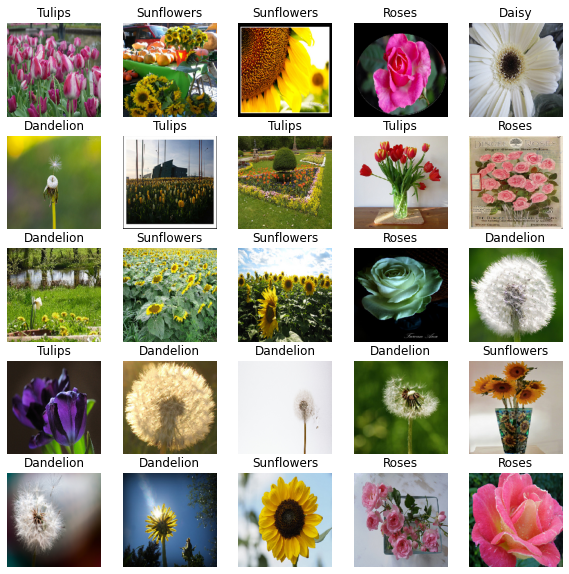

In [15]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

## 2) tf.data를 사용한 로드

위의 keras.processing 방법은 편리하지만 3가지 단점 존재
* 느리다.
* 세밀한 제어가 힘들다.
* 다른 TensorFlow와 잘 통합되지 않는다.

In [16]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [21]:
for f in list_ds.take(5): # list_ds에서 랜덤으로 5개 파일 추출
  print(f.numpy())

b'/home/kismi/.keras/datasets/flower_photos/sunflowers/4673984698_6ec14d5b79.jpg'
b'/home/kismi/.keras/datasets/flower_photos/sunflowers/184683023_737fec5b18.jpg'
b'/home/kismi/.keras/datasets/flower_photos/daisy/21402054779_759366efb0_n.jpg'
b'/home/kismi/.keras/datasets/flower_photos/tulips/4604238410_bcec9da4a0_n.jpg'
b'/home/kismi/.keras/datasets/flower_photos/daisy/8120563761_ed5620664f_m.jpg'


In [53]:
# 파일 경로를 (img, label) 쌍으로 변환
def get_label(file_path):
  # 파일경로를 path components의 list로 변환
  parts = tf.strings.split(file_path, os.path.sep)
  # parts 배열의 뒤에서 두번째가 class 디렉토리명
  return parts[-2] == CLASS_NAMES

In [54]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [60]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [62]:
# Dataset.map의 데이터 세트 작성
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [64]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False False  True False False]


In [65]:
# 훈련(학습)을 위한 기본 방법
# dataset으로 모델을 학습시키려면 데이터가 필요
# 데이터는 -> 잘 섞고, 일괄 처리하고, 가능한 빨리 batch를 사용 할 수 있어야 함.
# tf.data API를 통해 가능
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [69]:
train_ds = prepare_for_training(labeled_ds)
image_batch, label_batch = next(iter(train_ds))

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.bool)>


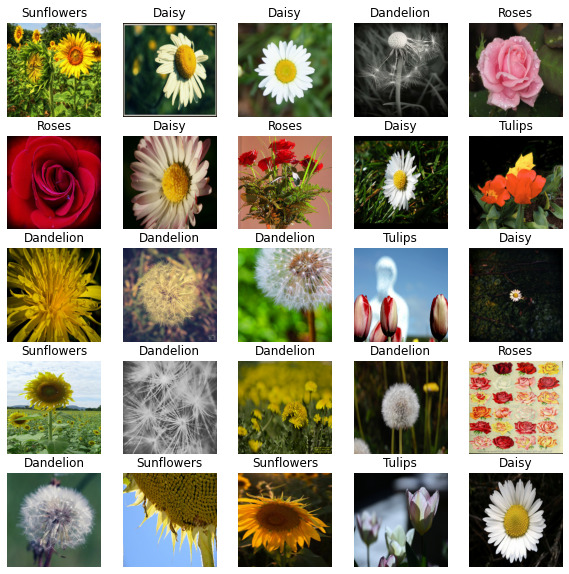

In [74]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [75]:
# keras.preprocessing과 tf.data의 성능확인
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))

In [76]:
# `keras.preprocessing`
timeit(train_data_gen)

....................................................................................................
1000 batches: 92.06706857681274 s
347.57270 Images/s


In [77]:
# `tf.data`
timeit(train_ds)

....................................................................................................
1000 batches: 7.9264280796051025 s
4037.12740 Images/s


In [78]:
# 위의 결과를 보면 tf.data가 훨씬 빠르다는 것을 알 수 있음(약 13배)
# 성능향상의 대부분은 .cache를 사용함에 있음
# 만약 tf.data API에서 cache를 사용하지 않으면 약 5배 더 느려지는 것을 볼 수 있음
uncached_ds = prepare_for_training(labeled_ds, cache=False)
timeit(uncached_ds)

....................................................................................................
1000 batches: 41.17677688598633 s
777.13708 Images/s


In [79]:
# keras.preprocessing도 cache 기능을 사용하면 약 4.5배 빨라짐
# dataset이 메모리에 맞지 않으면 cache 파일을 사용 할 것
filecache_ds = prepare_for_training(labeled_ds, cache="./flowers.tfcache")
timeit(filecache_ds)

....................................................................................................
1000 batches: 22.800997972488403 s
1403.44734 Images/s
